In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import cv2


# internal libraries
import calibration
import features
import matrix
import config
import draw

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
def load_data(imageset='2', rectified=False):
    folder = f"seq50{'rect' if rectified else 'unrect'}{imageset}"
    camera_folder = pathlib.Path(f'./../dataset/{folder}')
    calib_folder = pathlib.Path('./../dataset/calibration')

    images = list(camera_folder.iterdir())
    images = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in images]
    calibs = list(calib_folder.iterdir())
    calibs = [cv2.imread(str(img), cv2.IMREAD_GRAYSCALE) for img in calibs]
    return images, calibs

# Unrectified

In [54]:
images, calibs = load_data()

### Calibrate

In [55]:
camera_matrix = calibration.calibrate(calibs)

### Find Features

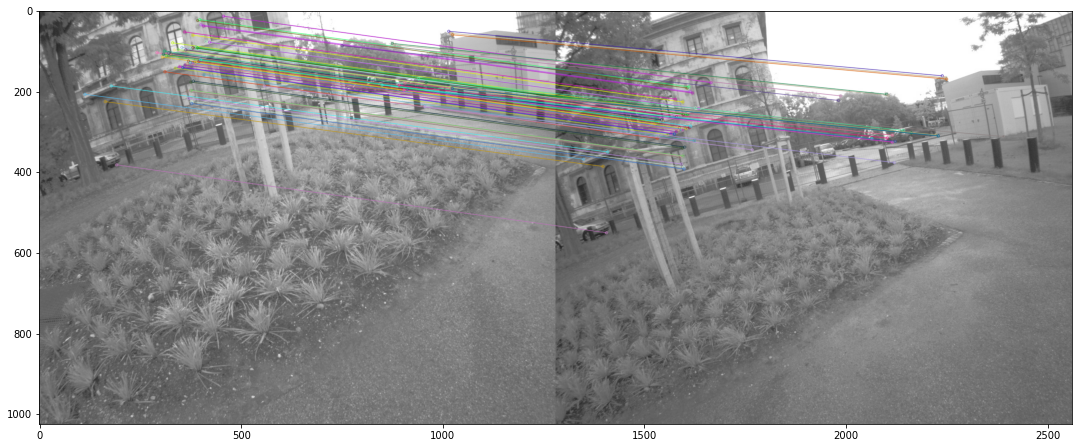

In [56]:
kp1, kp2, good = features.sift_features(images[0], images[1], good_ratio=0.5)
draw.feature_matches(images[0], images[1], kp1, kp2, good)

### Find Essential, Projection and Fundamental Matrix

In [57]:
kp1, kp2 = features.select_good_features(kp1, kp2, good)

In [58]:
src_pts = kp1.reshape(-1,1,2)
dst_pts = kp2.reshape(-1,1,2)

In [59]:
# essential matrix
E, mask = cv2.findEssentialMat(
    src_pts, dst_pts, camera_matrix, cv2.RANSAC, 0.5
)
rot1, rot2, trans = cv2.decomposeEssentialMat(E)

In [77]:
# projection matrix (try rerunning if exception happens)
solution = matrix.find_projection_matrix(
    camera_matrix, src_pts, dst_pts, rot1, rot2, trans, choices=10
)
P1 = solution['pro_mat_1st']
P2 = solution['pro_mat_2nd']

In [74]:
# fundamental matrix
F = matrix.calc_fundamental_matrix(camera_matrix, E)

In [78]:
F2, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_LMEDS)

In [82]:
np.divide(F, F2)

array([[ 8.11188429, -3.31294135,  1.14466032],
       [-7.62903454, -0.64467444,  1.14364102],
       [ 1.36774354,  1.36162041,  1.        ]])

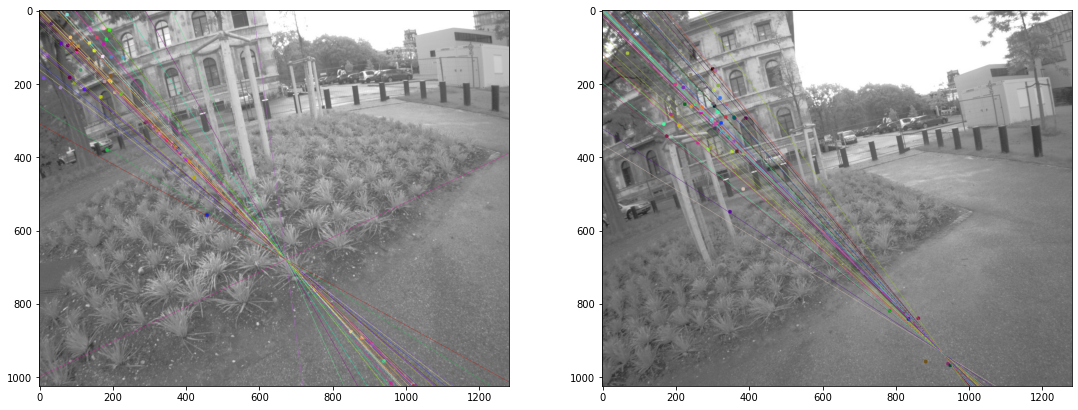

In [75]:
draw.epilines(images[0], images[1], src_pts, dst_pts, F)

### Triangulate points (todo?)

In [43]:
pts_3d = cv2.triangulatePoints(
    solution['pro_mat_1st'], solution['pro_mat_2nd'], src_pts, dst_pts
)

In [90]:
def run(rectify, other_mtx, estimate_fundamental=False):
    images, calibs = load_data(rectified=rectify)
    if other_mtx:
        fx = config.CAMERA_CALIBRATION[0]
        fy = config.CAMERA_CALIBRATION[1]
        cx = config.CAMERA_CALIBRATION[2]
        cy = config.CAMERA_CALIBRATION[3]

        camera_matrix = np.array(
            [[fx, 0, cx],
            [0, fy, cy],
            [0, 0, 1]]
        )
    else:
        camera_matrix = calibration.calibrate(calibs)
    kp1, kp2, good = features.sift_features(images[0], images[1], good_ratio=0.5)
    kp1, kp2 = features.select_good_features(kp1, kp2, good)
    src_pts = kp1.reshape(-1,1,2)
    dst_pts = kp2.reshape(-1,1,2)
    
    E, mask = cv2.findEssentialMat(
        src_pts, dst_pts, camera_matrix, cv2.RANSAC, 0.5
    )
    rot1, rot2, trans = cv2.decomposeEssentialMat(E)
    F = matrix.calc_fundamental_matrix(camera_matrix, E)
    if estimate_fundamental:
        F, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_LMEDS)
        src_pts = src_pts[mask.ravel()==1]
        dst_pts = dst_pts[mask.ravel()==1]
    draw.epilines(images[0], images[1], src_pts, dst_pts, F)

### Compare rectified and calibration matrix

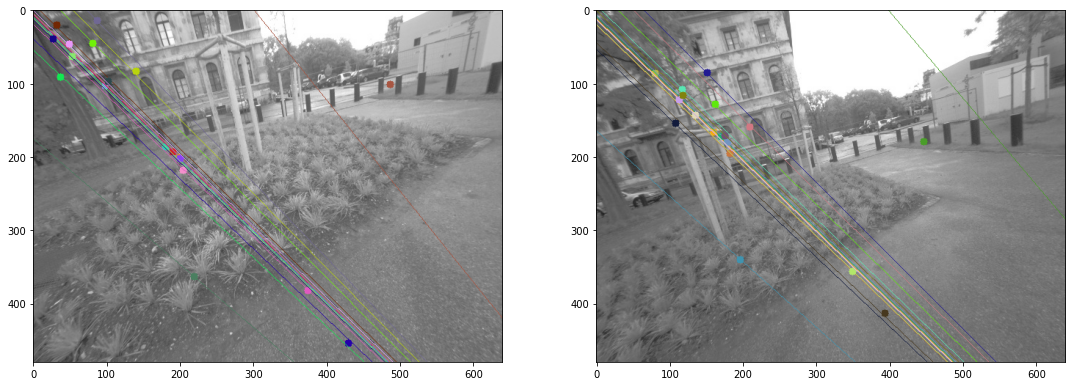

In [84]:
print('Rectified and calibrated')
run(True, False)

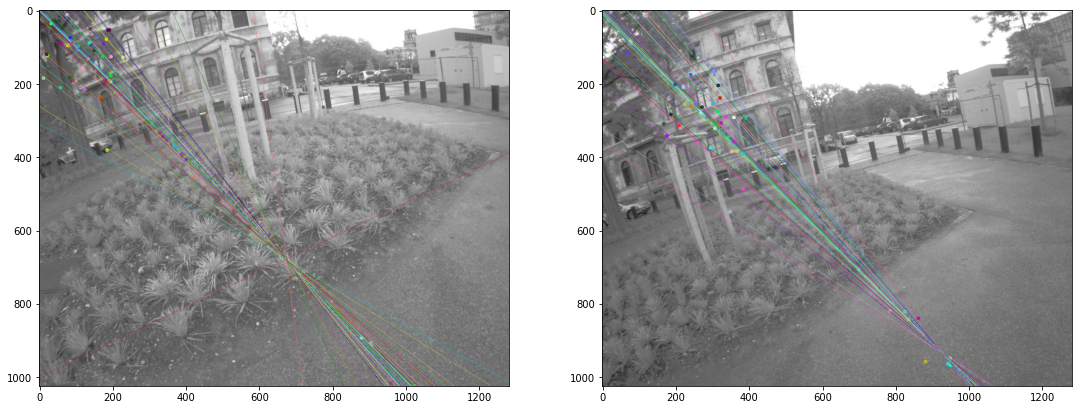

In [85]:
print('UnRectified and calibrated')
run(False, False)

Rectified and calibrated 2


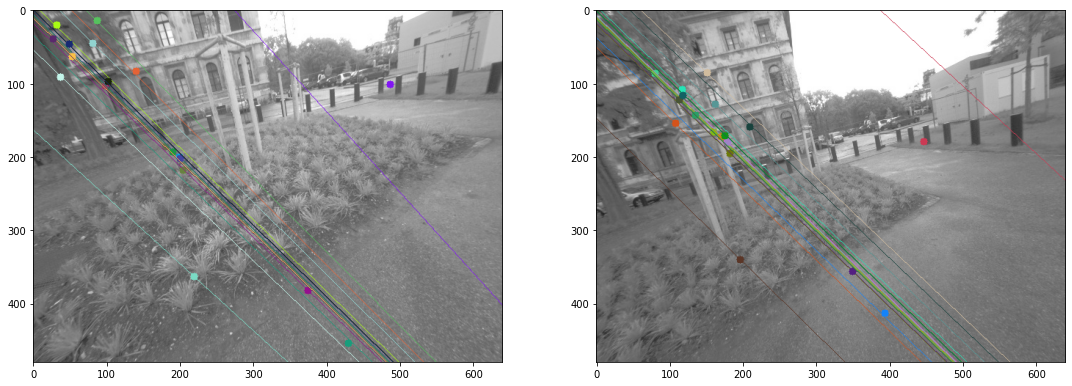

In [87]:
print('Rectified and calibrated 2')
run(True, True)

UnRectified and calibrated 2


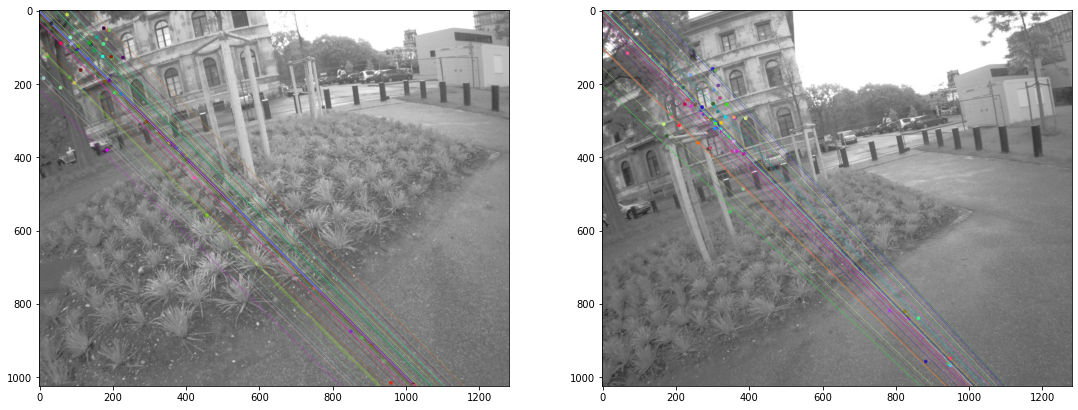

In [88]:
print('UnRectified and calibrated 2')
run(False, True)

### Compare fundamental matrix calculation

Original calculation


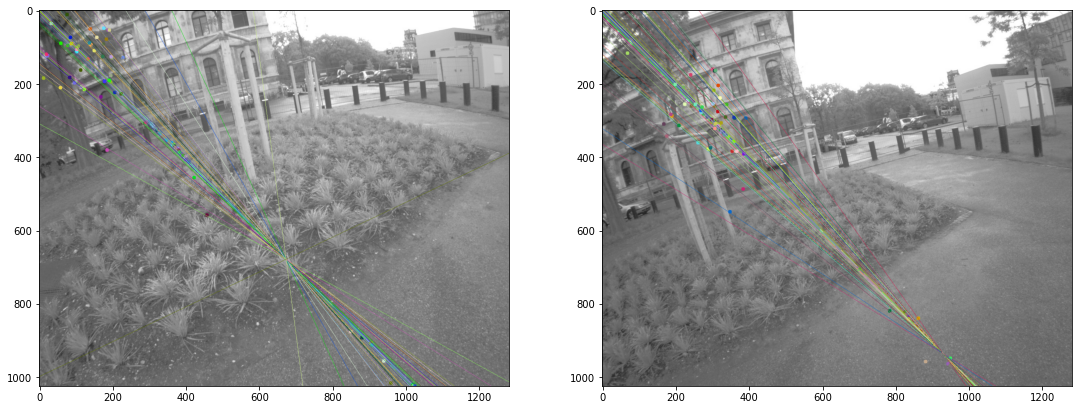

In [91]:
print('Original calculation')
run(rectify=False, other_mtx=False, estimate_fundamental=False)

Estimation


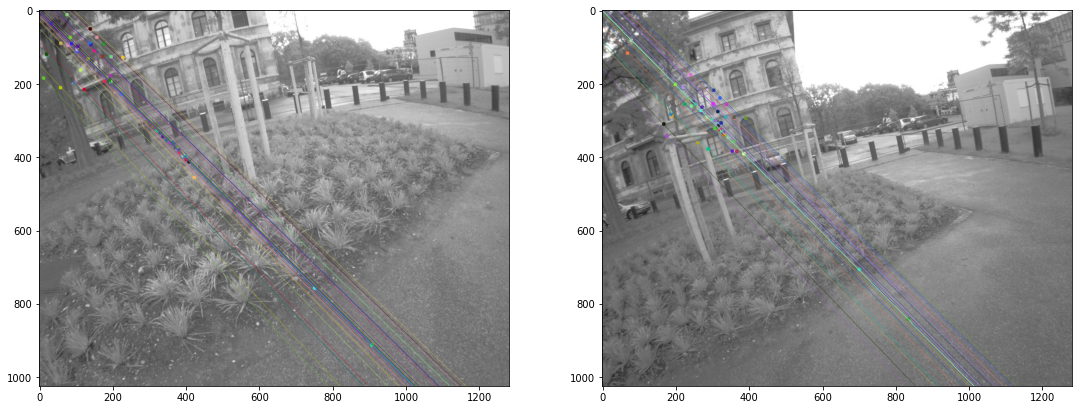

In [94]:
print('Estimation')
run(rectify=False, other_mtx=False, estimate_fundamental=True)